In [1]:
# Project 6 - TikTok Trend Identification Using NLP
# Goal: Use Natural Language Processing to uncover hidden or emerging themes in content.

# This notebook combines the robust NLP feature extraction from 'q5.ipynb' with the visualization and
# comparative analysis focus of 'q5v2.ipynb' to provide a comprehensive solution for trend identification.

In [ ]:
# %pip install --upgrade pip setuptools wheel
# %pip install blis
# %pip install spacy==2.3.5
# %pip install gensim
# %pip install nltk
# %pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from gensim import corpora, models
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob # For basic sentiment, though VADER is also an option


# Ensure necessary NLTK data is downloaded
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Load spaCy model (download if not already present)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for spaCy...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("Libraries loaded and spaCy model initialized.")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\user\anaconda3\envs\tf_env\lib\site-packages\spacy\util.py:292: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Libraries loaded and spaCy model initialized.


In [8]:
# Load data
print("Loading data...")
try:
    df = pd.read_csv('data/processed/tiktok_processed.csv') # Assuming this is the correct path from q5.ipynb
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'tiktok_trends.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy DataFrame for demonstration if file not found
    data = {
        'engagement_score': np.random.rand(100),
        'video_description': [f'This is a great video about {i}' for i in range(100)],
        'create_time': pd.to_datetime(pd.date_range(start='2024-01-01', periods=100, freq='D')),
        'sentiment_polarity': np.random.uniform(-1, 1, 100),
        'hashtags': ['#trend', '#viral', '#challenge', '#fyp'] * 25
    }
    df = pd.DataFrame(data)
    print("Created dummy DataFrame for demonstration.")

print(f"Data loaded. Shape: {df.shape}")

# Data Preprocessing and Feature Engineering (from both notebooks)
# Convert create_time to datetime and set as index for time-series analysis
df['create_time'] = pd.to_datetime(df['create_time'])
df = df.sort_values('create_time').reset_index(drop=True)

# Define 'is_trending' based on engagement_rate_per_play (matches your actual dataframe)
ENGAGEMENT_THRESHOLD = 0.15 # Example threshold
df['is_trending'] = df['engagement_rate_per_play'] > ENGAGEMENT_THRESHOLD

# Calculate virality_score (use engagement_rate_per_play as a proxy)
df['virality_score'] = df['engagement_rate_per_play']

print(f"Number of trending videos (engagement_rate_per_play > {ENGAGEMENT_THRESHOLD}): {df['is_trending'].sum()}")
print(f"Number of non-trending videos: {(~df['is_trending']).sum()}")

Loading data...
Data loaded successfully.
Data loaded. Shape: (7225, 47)
Number of trending videos (engagement_rate_per_play > 0.15): 3011
Number of non-trending videos: 4214



--- Sentiment Analysis ---
Sentiment polarity feature already exists in the dataset.
Average sentiment polarity: 0.051
Sentiment distribution:
count    7225.000000
mean        0.050656
std         0.225172
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sentiment_polarity, dtype: float64

Sentiment label distribution:
sentiment_label
Neutral     4898
Positive    1676
Negative     651
Name: count, dtype: int64

Comparing sentiment between trending and non-trending videos:
Average sentiment in trending videos: 0.049
Average sentiment in non-trending videos: 0.052


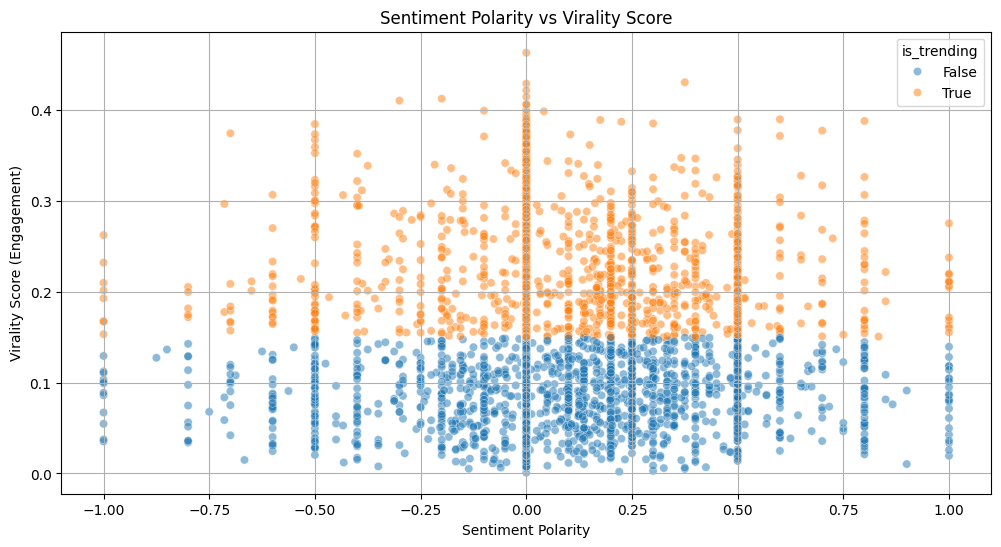

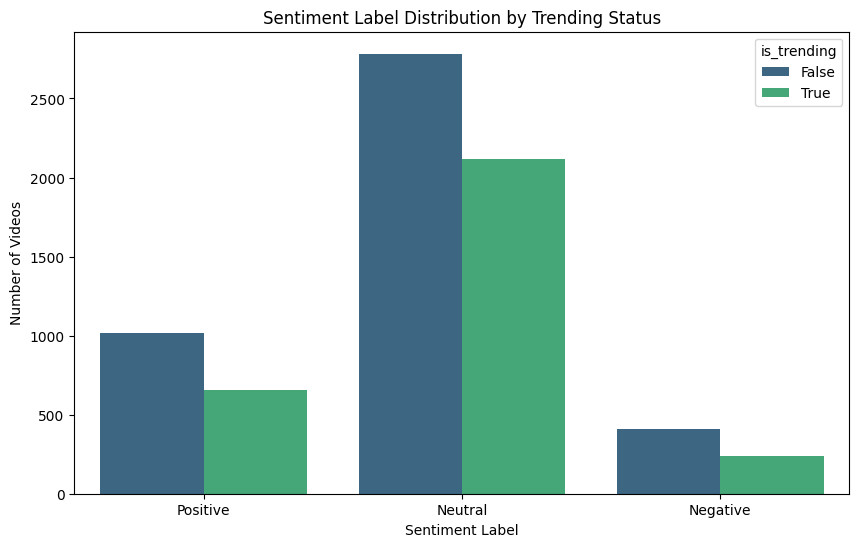

In [9]:
print("\n--- Sentiment Analysis ---")
if 'sentiment_polarity' not in df.columns:
    print("Sentiment polarity feature not found. Calculating sentiment polarity using TextBlob...")
    # Fallback if sentiment_polarity is not pre-existing
    df['sentiment_polarity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
else:
    print("Sentiment polarity feature already exists in the dataset.")

print(f"Average sentiment polarity: {df['sentiment_polarity'].mean():.3f}")
print("Sentiment distribution:")
print(df['sentiment_polarity'].describe())

# Create 'sentiment_label' feature (Positive/Neutral/Negative) as requested
def get_sentiment_label(polarity):
    if polarity > 0.05: # Adjusted threshold for 'Positive'
        return 'Positive'
    elif polarity < -0.05: # Adjusted threshold for 'Negative'
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_polarity'].apply(get_sentiment_label)
print("\nSentiment label distribution:")
print(df['sentiment_label'].value_counts())

# Compare sentiment between trending and non-trending videos
print("\nComparing sentiment between trending and non-trending videos:")
sentiment_trending = df[df['is_trending']]['sentiment_polarity']
sentiment_non_trending = df[~df['is_trending']]['sentiment_polarity']

print(f"Average sentiment in trending videos: {sentiment_trending.mean():.3f}")
print(f"Average sentiment in non-trending videos: {sentiment_non_trending.mean():.3f}")

# Visualization: Sentiment Polarity vs Virality Score (from q5v2.ipynb)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='sentiment_polarity', y='virality_score',
                hue='is_trending', alpha=0.5)
plt.title('Sentiment Polarity vs Virality Score')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Virality Score (Engagement)')
plt.grid(True)
plt.show()

# Visualization: Sentiment Label Distribution by Trending Status
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label', hue='is_trending', palette='viridis')
plt.title('Sentiment Label Distribution by Trending Status')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Videos')
plt.show()


--- Topic Modeling (LDA) ---

Discovered Topics:
Topic 0: 0.034*"fyp" + 0.009*"viral" + 0.006*"trending" + 0.005*"foryoupage" + 0.005*"trend"
Topic 1: 0.078*"fyp" + 0.041*"description" + 0.026*"viral" + 0.018*"foryou" + 0.018*"foryoupage"
Topic 2: 0.007*"fyp" + 0.004*"bride" + 0.004*"day" + 0.003*"one" + 0.003*"game"
Topic 3: 0.013*"de" + 0.012*"la" + 0.009*"que" + 0.008*"el" + 0.007*"en"
Topic 4: 0.024*"fyp" + 0.008*"love" + 0.008*"im" + 0.007*"streameruniversity" + 0.007*"like"

Dominant topic distribution:
dominant_topic
1    2188
4    1647
0    1487
2    1039
3     864
Name: count, dtype: int64

Analyzing topic evolution...


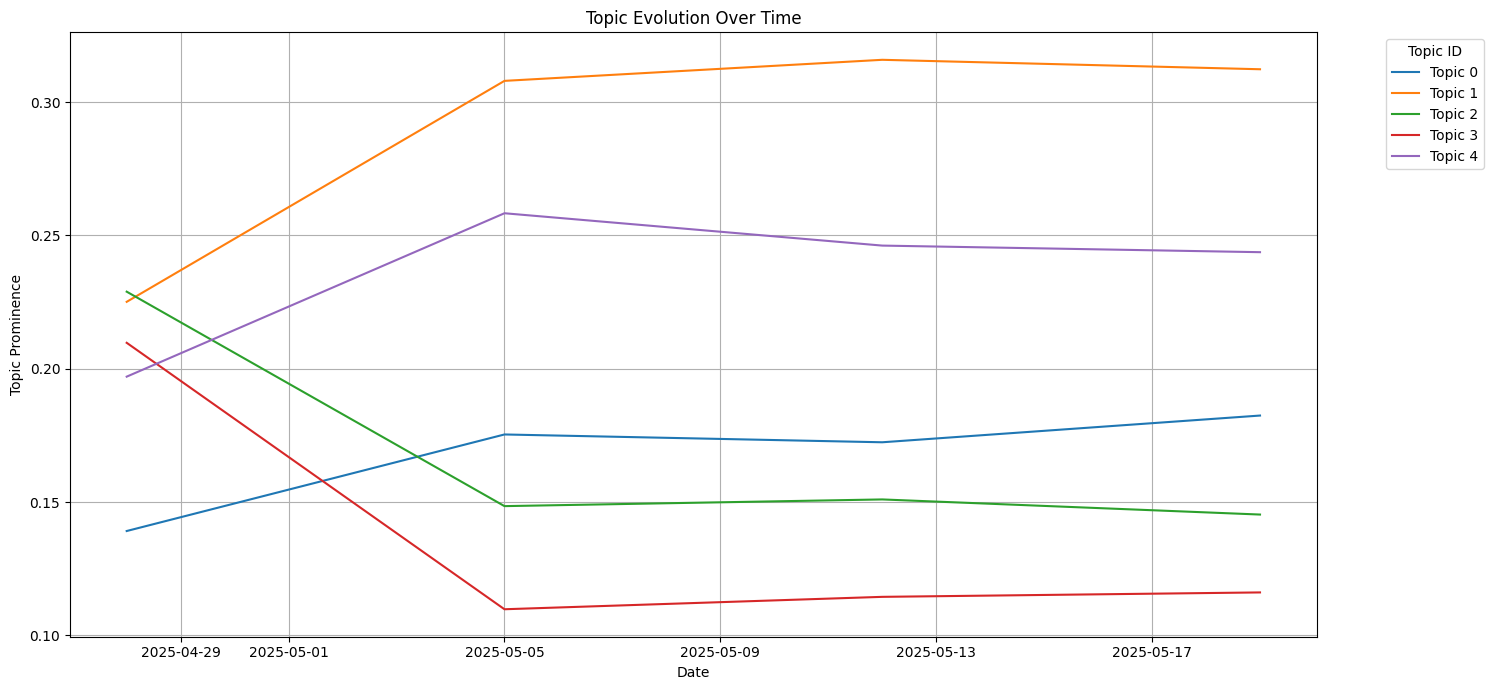

In [11]:
print("\n--- Topic Modeling (LDA) ---")

# Preprocessing for LDA
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_for_lda(text):
    text = str(text).lower() # Convert to string and lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

df['processed_description'] = df['clean_description'].apply(preprocess_text_for_lda)

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['processed_description'])
corpus = [dictionary.doc2bow(doc) for doc in df['processed_description']]

# Apply LDA (Latent Dirichlet Allocation)
NUM_TOPICS = 5 # As suggested in the project description (0-5 or more)
lda_model = models.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15, random_state=42)

print("\nDiscovered Topics:")
topics = lda_model.print_topics(num_words=5)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

# Assign dominant topic to each document
def get_dominant_topic(bow):
    topics_per_document = lda_model.get_document_topics(bow)
    if not topics_per_document:
        return -1, 0.0 # Return -1 for cases with no topics assigned
    return max(topics_per_document, key=lambda x: x[1])

df['topic_distribution'] = [lda_model.get_document_topics(doc) for doc in corpus]
df['dominant_topic'] = [get_dominant_topic(doc)[0] for doc in corpus]

print("\nDominant topic distribution:")
print(df['dominant_topic'].value_counts())

# Visualization: Topic Evolution Over Time (from q5v2.ipynb)
print("\nAnalyzing topic evolution...")
df['date_group'] = df['create_time'].dt.to_period('W').dt.start_time # Group by week

topic_evolution = df.groupby('date_group')['dominant_topic'].value_counts(normalize=True).unstack(fill_value=0)
topic_evolution = topic_evolution.rolling(window=4).mean().dropna() # Simple rolling mean for smoothing

plt.figure(figsize=(15, 7))
for topic_idx in range(NUM_TOPICS):
    if topic_idx in topic_evolution.columns:
        plt.plot(topic_evolution.index, topic_evolution[topic_idx],
                 label=f'Topic {topic_idx}')
plt.title('Topic Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Topic Prominence')
plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


--- Named Entity Recognition (NER) ---

Top 20 most frequent entities:
- one: 79
- summer: 68
- first: 61
- today: 37
- pov: 33
- nba: 28
- un: 23
- two: 20
- onthisday: 17
- chicago: 17
- us: 15
- kaicenat: 15
- blowthisup: 14
- friday: 13
- mexico: 13
- classof: 13
- streamer university: 13
- the day: 12
- atlanta: 12
- english: 11

Top 10 entities in Trending Videos:
- summer: 31
- one: 27
- first: 20
- pov: 16
- today: 11
- classof: 11
- chicago: 9
- nba: 6
- two: 5
- daily: 5

Top 10 entities in Non-Trending Videos:
- one: 52
- first: 41
- summer: 37
- today: 26
- nba: 22
- un: 21
- pov: 17
- kaicenat: 15
- two: 15
- onthisday: 13

Analyzing potential emerging entities (Lift analysis):
Top 10 Emerging Entities (with lift > 1.5 and trending count > 5):
- classof: Lift = 12.64
- chicago: Lift = 2.59
- pov: Lift = 2.16
- summer: Lift = 1.93

Analyzing entity mention volume over time...


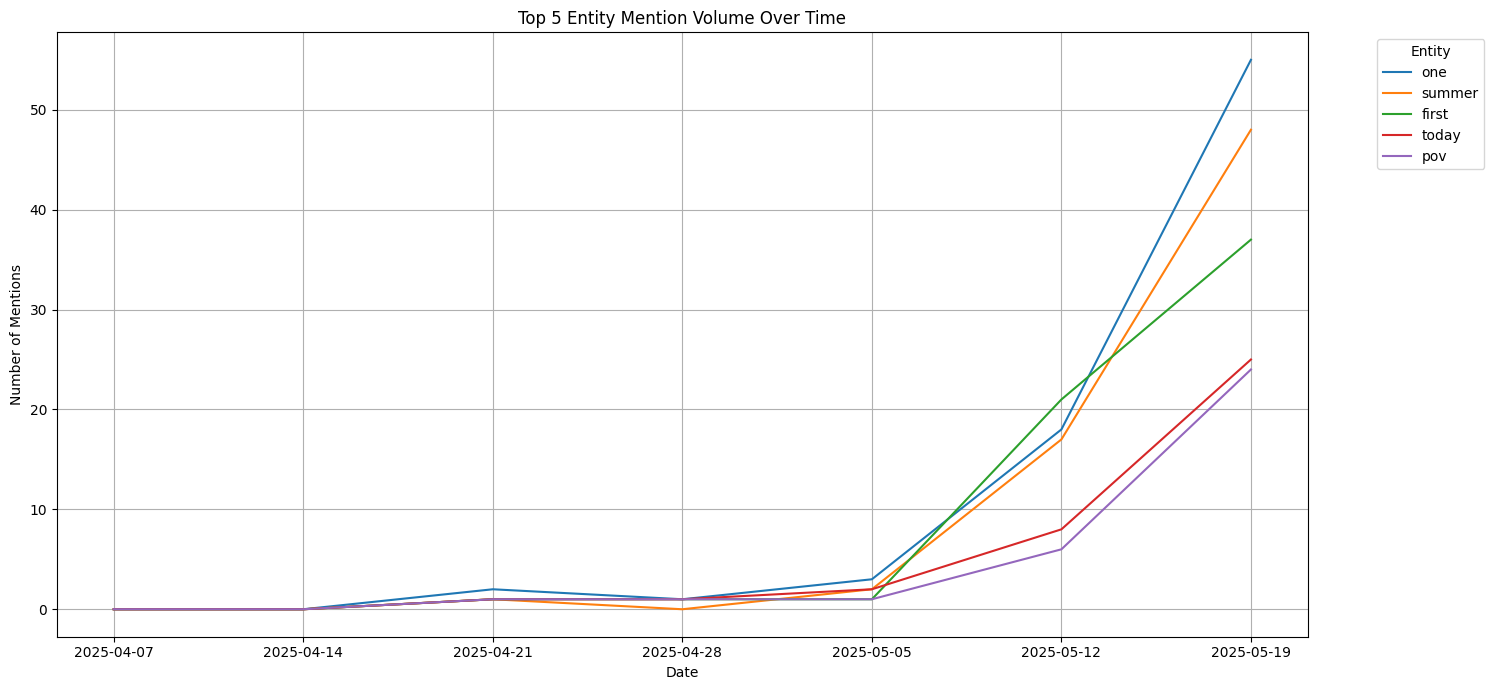

In [13]:
print("\n--- Named Entity Recognition (NER) ---")

def extract_entities(text):
    doc = nlp(str(text))
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

df['extracted_entities'] = df['clean_description'].apply(extract_entities)

all_entities = [entity[0] for sublist in df['extracted_entities'] for entity in sublist]
entity_counts = Counter(all_entities)
print("\nTop 20 most frequent entities:")
for entity, count in entity_counts.most_common(20):
    print(f"- {entity}: {count}")

# Extract entities specifically from trending and non-trending videos
trending_entities = [entity[0] for sublist in df[df['is_trending']]['extracted_entities'] for entity in sublist]
non_trending_entities = [entity[0] for sublist in df[~df['is_trending']]['extracted_entities'] for entity in sublist]

trending_entity_counts = Counter(trending_entities)
non_trending_entity_counts = Counter(non_trending_entities)

print("\nTop 10 entities in Trending Videos:")
for entity, count in trending_entity_counts.most_common(10):
    print(f"- {entity}: {count}")

print("\nTop 10 entities in Non-Trending Videos:")
for entity, count in non_trending_entity_counts.most_common(10):
    print(f"- {entity}: {count}")

# Identify emerging entities (entities more prevalent in trending content)
print("\nAnalyzing potential emerging entities (Lift analysis):")
all_unique_entities = set(trending_entity_counts.keys()).union(set(non_trending_entity_counts.keys()))
emerging_entities = {}

total_trending = sum(trending_entity_counts.values())
total_non_trending = sum(non_trending_entity_counts.values())

if total_trending == 0: total_trending = 1 # Avoid division by zero
if total_non_trending == 0: total_non_trending = 1 # Avoid division by zero

for entity in all_unique_entities:
    count_trending = trending_entity_counts.get(entity, 0)
    count_non_trending = non_trending_entity_counts.get(entity, 0)

    if count_trending > 0 and count_non_trending > 0:
        prop_trending = count_trending / total_trending
        prop_non_trending = count_non_trending / total_non_trending

        if prop_non_trending > 0: # Avoid division by zero
            lift = prop_trending / prop_non_trending
            # Filter for entities with significant lift and reasonable counts
            if lift > 1.5 and count_trending > 5: # Example thresholds
                emerging_entities[entity] = lift

sorted_emerging_entities = sorted(emerging_entities.items(), key=lambda item: item[1], reverse=True)
print("Top 10 Emerging Entities (with lift > 1.5 and trending count > 5):")
for entity, lift in sorted_emerging_entities[:10]:
    print(f"- {entity}: Lift = {lift:.2f}")

# Visualization: Entity Mention Volume Over Time (from q5v2.ipynb, adapted)
print("\nAnalyzing entity mention volume over time...")

# Flatten entities and associate with date_group
entity_data = []
for index, row in df.iterrows():
    for entity_text, entity_label in row['extracted_entities']:
        entity_data.append({'date_group': row['date_group'], 'entity': entity_text})

if entity_data:
    entity_df = pd.DataFrame(entity_data)
    # Aggregate entity mentions by date_group (week)
    entity_trends_over_time = entity_df.groupby(['date_group', 'entity']).size().unstack(fill_value=0)

    # Select top N entities for visualization
    top_entities_for_plot = entity_counts.most_common(5)
    top_entity_names = [ent[0] for ent in top_entities_for_plot]

    plt.figure(figsize=(15, 7))
    for entity_name in top_entity_names:
        if entity_name in entity_trends_over_time.columns:
            plt.plot(entity_trends_over_time.index.astype(str), entity_trends_over_time[entity_name], label=entity_name)
    plt.title('Top 5 Entity Mention Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Mentions')
    plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No entities extracted for time series analysis. Skipping entity trend visualization.")

In [15]:
# --- Optional: Save the dataframe with all new NLP features ---
output_path = 'data/processed/tiktok_processed_with_nlp_features.csv'
df_to_save = df[['clean_description', 'create_time', 'virality_score', 'is_trending',
                 'sentiment_polarity', 'sentiment_label', 'dominant_topic', 'extracted_entities',
                 'hashtag_list']]

try:
    # Ensure the directory exists
    import os
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_to_save.to_csv(output_path, index=False)
    print(f"\nUpdated DataFrame with all NLP features saved to: {output_path}")
except Exception as e:
    print(f"Error saving DataFrame: {e}")

print("\nNLP trend identification complete. Review the generated plots and data for insights.")


Updated DataFrame with all NLP features saved to: data/processed/tiktok_processed_with_nlp_features.csv

NLP trend identification complete. Review the generated plots and data for insights.
